In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint
from itertools import combinations
from math import ceil
from scipy.stats import linregress
from collections import defaultdict
from Bio import SeqIO
from math import ceil

In [24]:
## Read in data; use the ID to index individual oligos
counts = pd.read_excel('../data/counts/2017.09.28.annotatedCounts.xlsx', index_col=0)
outfile = '../data/counts/2017-09-28_proportions.csv'

In [25]:
def proportions(df):
    ''' For each column, divide each element by the sum of the column (column sums to 1)'''
    xsum=df.sum(0)
    df = df.div(xsum, axis='columns')
    return df

def standardize_subset_data(df, pattern, fn):
    ''' Pull columns that contain the pattern (case insensitive) and apply the standardization function, fn'''
    subset = df[ [c for c in df.columns.values if pattern.upper() in c.upper()] ]
    standardized_subset = fn(subset)
    
    return standardized_subset
    
### For convenience, separate out the metadata, input counts and background counts.
### Standardize each column while we're at it

input_ctrl = standardize_subset_data(counts, 'input', proportions) # Input samples
bkgd_ctrl =  standardize_subset_data(counts, 'beads', proportions) # Beads only background samples
metadata = counts[['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']] # Metadata

In [26]:
sns.set(style='whitegrid', font_scale = 1.3, palette='pastel') ## Make all of our plots prettier

def compare_replicates(df, columns, title):
    ''' Plot sanity checks for technical replicates '''
    if columns:
        replicates = df[columns]    
        replicates.fillna(0, inplace=True)
    else:
        replicates = df
    
    def plot_comparison(x,y, **kwargs):
        r_2 = linregress(x,y)[2]
        scatter = plt.plot(x,y, 'o', alpha=0.4)
        scatter[0].axes.text(0,0, 'R^2 = %.2f'%(r_2))
        return scatter
        
    g = sns.PairGrid(replicates, diag_sharey=False)
    g.map_diag(sns.violinplot)
    g.map_offdiag(plot_comparison, )
    
    g.fig.suptitle(title, va='bottom')
    plt.tight_layout()
    plt.show()

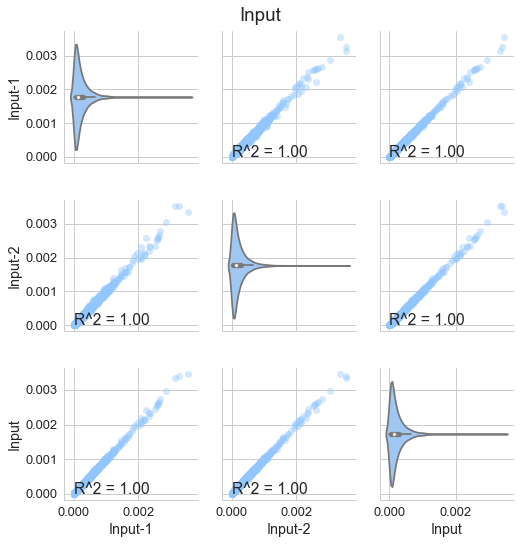

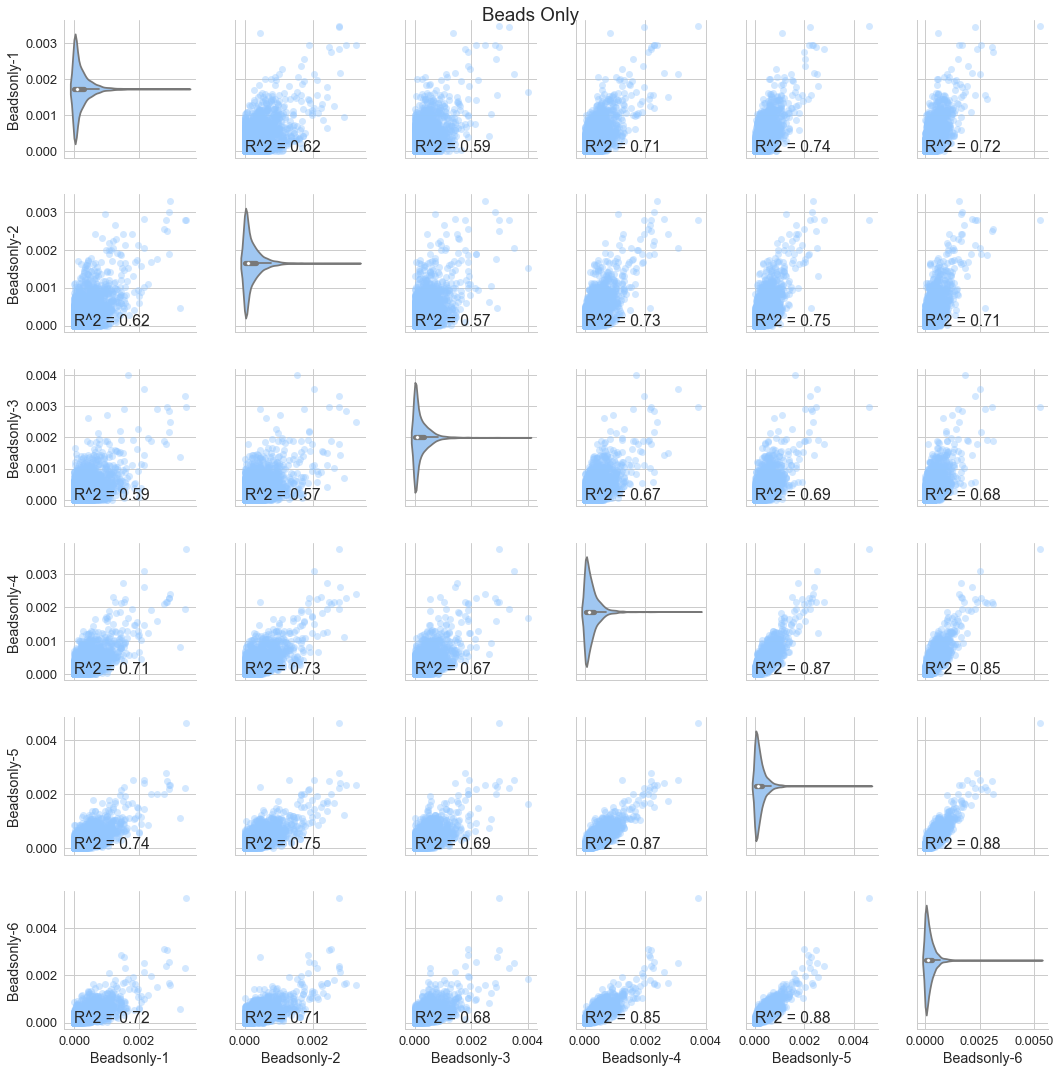

In [27]:
## Sanity check the controls
compare_replicates(input_ctrl, None, 'Input')
compare_replicates(bkgd_ctrl, None, 'Beads Only')

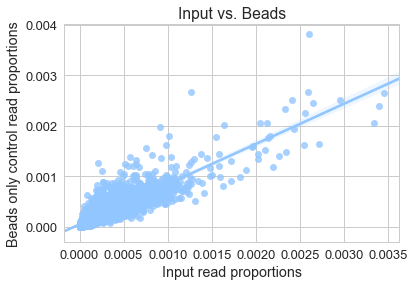

In [28]:
#### Clean up any funky replicates in the beads and/or input controls.
funky_background_replicates = ['Beadsonly-2', 'Beadsonly-3']
# bkgd_ctrl.drop(funky_background_replicates, axis=1, inplace=True) # Funky replicates

# funky_input_replicates = []
# input_ctrl.drop(funky_input_replicates, axis=1, inplace=True)


#### Find the mean of the input and background vals; compare these.
input_ctrl['average'] = input_ctrl.mean(axis=1)
bkgd_ctrl['average'] = bkgd_ctrl.mean(axis=1)

ax = sns.regplot(input_ctrl['average'], bkgd_ctrl['average'])
ax.set_xlabel('Input read proportions')
ax.set_ylabel('Beads only control read proportions')
ax.set_title('Input vs. Beads')

# print input_ctrl.max(), input_ctrl.mean()
# print bkgd_ctrl.max(), input_ctrl.mean()

### 1: Controls  
* Controls generally look good, with a roughly uniform distribution of reads across oligos (max p(oligo) = 0.003ish). 
* Technical replicates generally agree with each other, with the exception of two beads-only controls that clearly disagred with all other samples and were dropped.  
* Beads-only and input controls agree well with each other; go ahead and use the input controls downstream.  

#### Concerns  
* Input samples are identical (suspicious there was a reads -> counts error somewhere)  

In [34]:
output = proportions(counts[[c for c in counts.columns.values if not  # All "real" samples
                 any( ['beads' in c.lower(), 
                       'input' in c.lower(), 
                       c in metadata.columns.values] )
                ] ])

# print output.max(), output.mean()

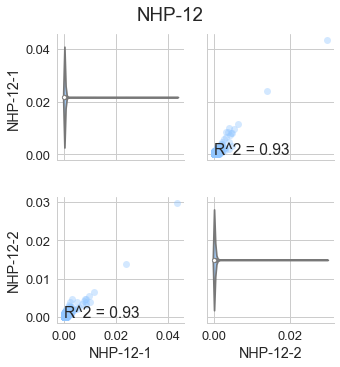

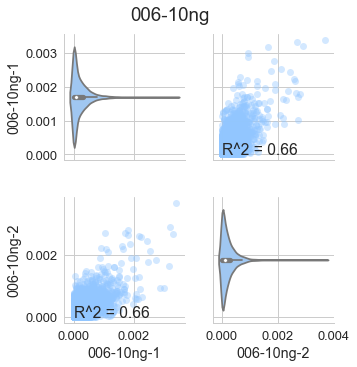

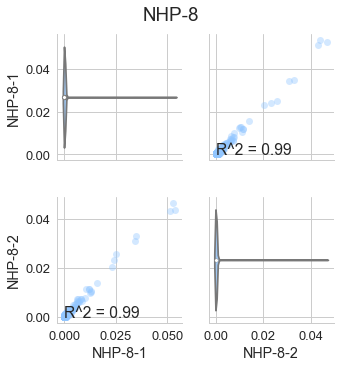

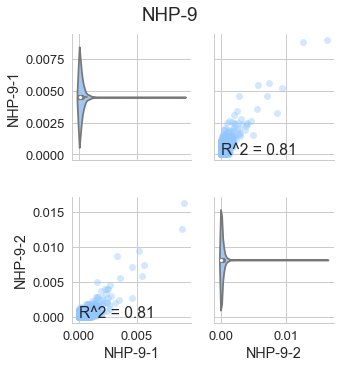

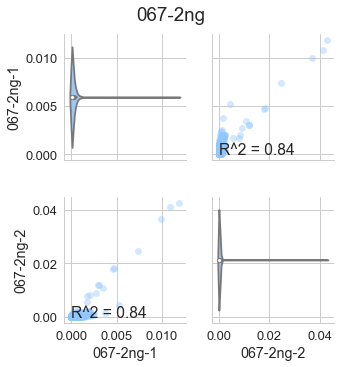

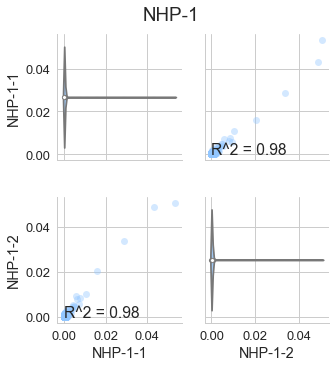

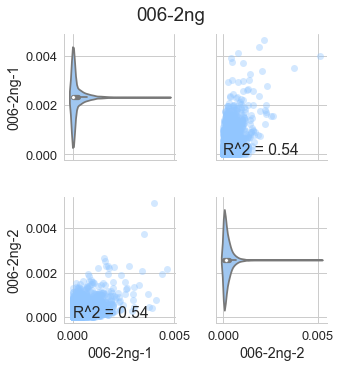

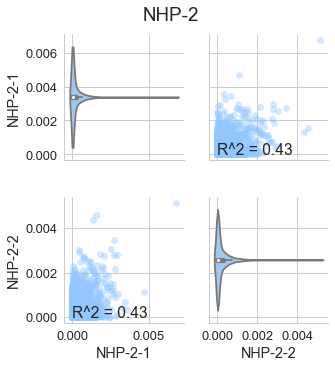

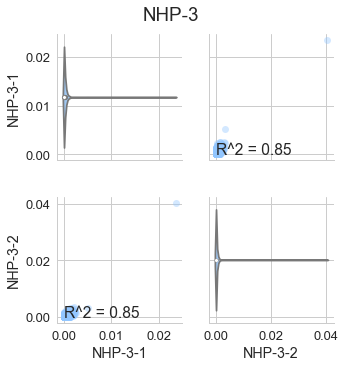

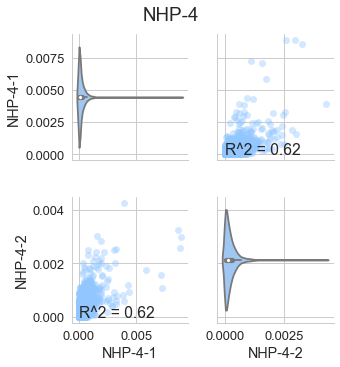

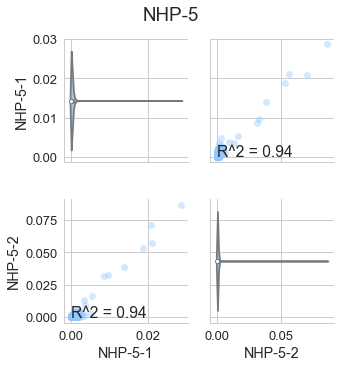

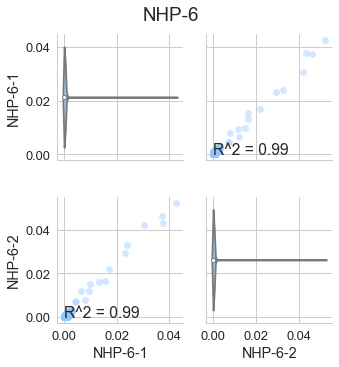

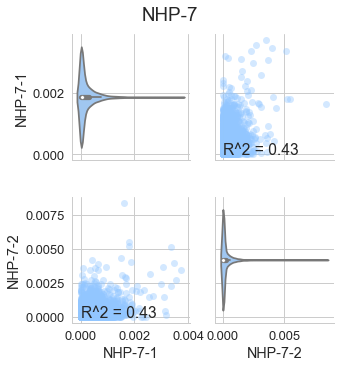

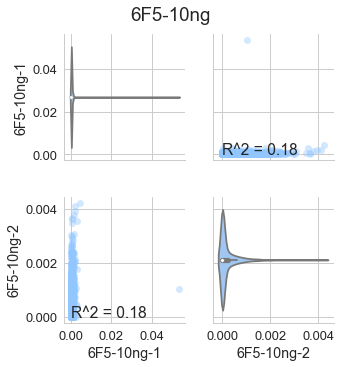

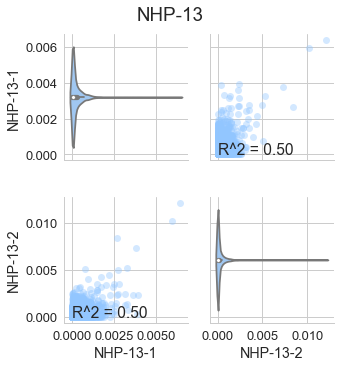

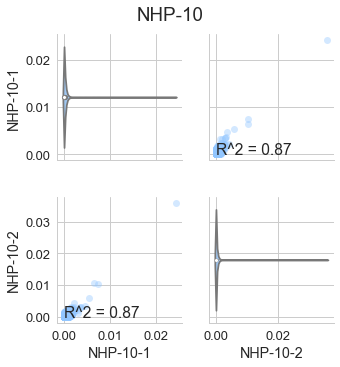

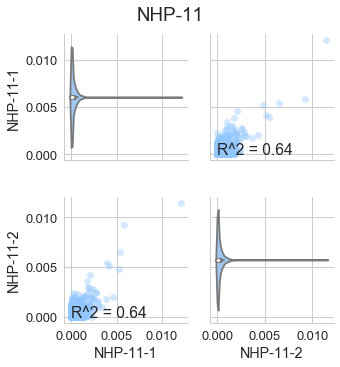

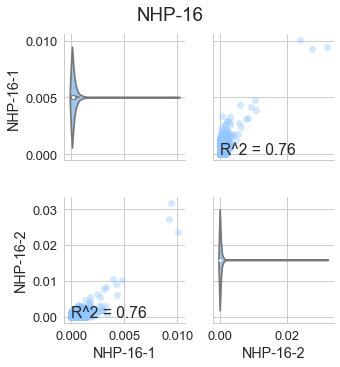

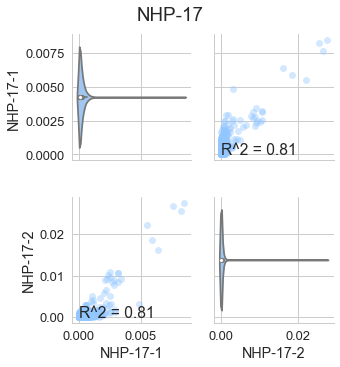

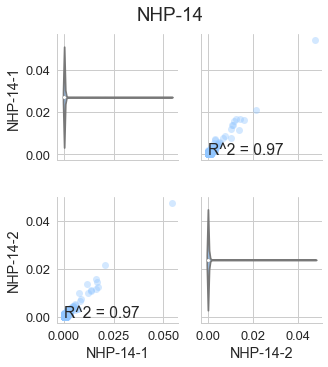

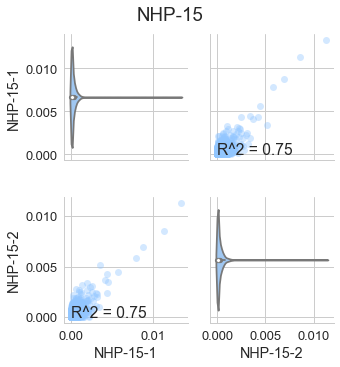

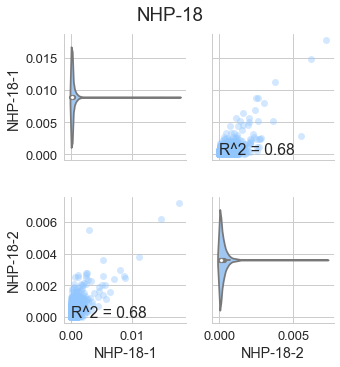

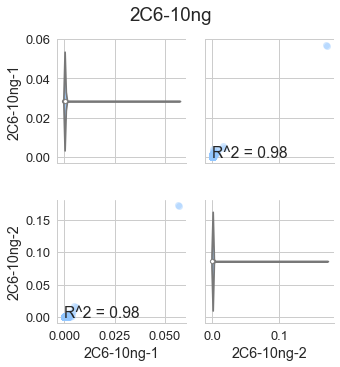

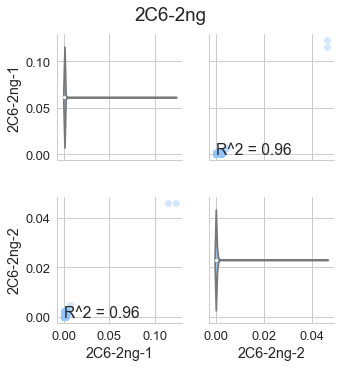

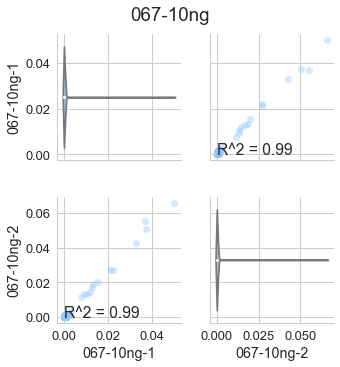

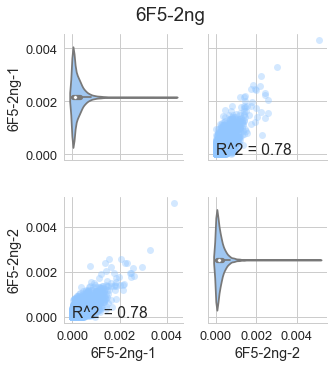

In [30]:
### Look at technical replicates for each sample
replicates = defaultdict(list)
for serum in output.columns.values:
    replicates[serum.rsplit('-', 1)[0]].append(serum) # Find replicates
replicates = dict(replicates) # Turn off defaultdict behavior

for sera, reps in replicates.items():
    compare_replicates(output, reps, sera)

In [40]:
## Add the names of any particular replicates that seem "off" relative to the others
funky_replicates = ['006-10ng-1', '006-10ng-2','006-2ng-1', '006-2ng-2','NHP-2-1', 'NHP-2-2', 'NHP-4-1', 'NHP-4-2', 'NHP-7-1', 'NHP-7-2', '6F5-10ng-1', 'NHP-13-1', 'NHP-13-2', 'NHP-11-1', 'NHP-11-2', 'NHP-18-2', '6F5-2ng-1', '6F5-2ng-2'] 

if funky_replicates != []:
    output.drop(funky_replicates, inplace=True, axis=1, errors='ignore')
    
## Aggregate technical replicates

aggregated_output = pd.DataFrame(index=output.index.values)

for sera, reps in replicates.items():
    try:
        aggregated_output[sera] = output[reps].mean(axis=1)
    except:
        continue
    
print aggregated_output.head()

         NHP-12     NHP-8     NHP-9   067-2ng     NHP-1     NHP-3     NHP-5  \
1      0.000776  0.000242  0.000275  0.000425  0.000638  0.000560  0.000423   
2      0.000175  0.000126  0.000459  0.000245  0.000202  0.000439  0.000346   
3.188  0.000326  0.000329  0.000427  0.000511  0.000415  0.000333  0.000510   
4.189  0.000574  0.000243  0.000387  0.000429  0.000794  0.000553  0.000371   
5.19   0.000355  0.000106  0.000270  0.000108  0.000048  0.000143  0.000531   

          NHP-6    NHP-10    NHP-16    NHP-17    NHP-14    NHP-15  2C6-10ng  \
1      0.000480  0.000574  0.000427  0.000332  0.003344  0.000261  0.000135   
2      0.000344  0.000520  0.000384  0.000161  0.003775  0.000490  0.000232   
3.188  0.000508  0.000270  0.000282  0.000212  0.000866  0.000105  0.000586   
4.189  0.000431  0.000558  0.000710  0.000427  0.000801  0.000487  0.000699   
5.19   0.000164  0.000217  0.000006  0.000185  0.000071  0.000005  0.000037   

        2C6-2ng  067-10ng  
1      0.000210  0.000

### 2: Samples  
* Most samples agree well between technical replicates. Most oligos are close to 0 for most samples (relatively clean data), but the distribution of reads is less uniform for samples than controls, with several replicated hits per sample.   
  
#### Concerns
* Some sera samples just didn't work well (max read proportion of < 0.01 and poor agreement between replicates). These were tossed.  
* Total read depth for samples is about the same as for controls; is this expected?  

In [41]:
### Tidy up the metadata a bit
metadata = counts[['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']] # Metadata

## Tidy start and end coordinates --> integers
metadata['start'], metadata['end'] = metadata['Start_to_End_nt'].str.split('to', 1).str
metadata['start'] = metadata['start'].map(lambda x: int(x))
metadata['end'] = metadata['end'].map(lambda x: int(x.split('.')[0])) ## TODO
metadata.drop('Start_to_End_nt', inplace=True, axis=1)

def parse_strains(virusstrain):
    
    if 'HIV' in virusstrain:
        # e.g., 'HIV_Env_QB850.72p.C14_A1.HIV_Env_QB850.632p.B10'
        gene = virusstrain.split('HIV_', 1)[1].split('_', 1)[0] # Env
        virus = 'HIV'+'_'+gene.upper() #HIV_ENV
        strains = virusstrain.split('HIV_%s_'%gene) # ['QB850.72p.C14_A1.', 'QB850.632p.B10']
        strains = [ s.replace('.', '').replace('_', '').replace('-', '').upper() for s in strains if s != '']
        # ['QB85072PC14A1', 'QB850632PB10']
        
        
    else:
        try:
            # e.g., 'DENV3_BR-BID-V2403-2008.DENV3_Mozambique1985'
            # The ONNV sequences overlap with the CHIKV sequences; for now, we'll omit it; this should be revisited. TODO
            names = [s for s in virusstrain.split('.') if 'ONNV' not in s] # ['DENV3_BR-BID-V2403-2008', 'DENV3_Mozambique1985']
            virus = [s.split('_', 1)[0] for s in names] # ['DENV3']
            assert len(set(virus)) == 1#, ('ERROR: Multiple viruses at this locus', virus)
            virus = virus[0] # 'DENV3'
            strains = [s.split(virus+'_', 1)[1].replace('-', '').replace('_', '').upper() for s in names if s != '']
            # ['BRBIDV24032008', 'MOZAMBIQUE1985']

        except Exception as e:
            return pd.Series({'virus': np.nan, 'strains':np.nan})
        
    return pd.Series({'virus': virus, 'strains':strains})

new_names = pd.DataFrame([parse_strains(v) for v in metadata['Virus_Strain']], columns=['virus', 'strains'])
metadata = metadata.join(new_names)

metadata.drop('Virus_Strain', axis=1, inplace=True)
metadata.dropna(how='any', inplace=True, axis=(0, 1))

def adjust_hiv(row):
    if 'HIV' in row['virus']:    
        HIV_map = {
        'HIV_GAG': 790,
        'HIV_POL': 2085,
        'HIV_ENV': 6225,
        'HIV_REV': 5970,
        'HIV_NEF': 8797,
        'HIV_VPU': 6062,
        'HIV_VPR': 5559,
        'HIV_VIF': 5041, 
        'HIV_TAT': 5831}

        row['start'] += HIV_map[row['virus']]
        row['end'] += HIV_map[row['virus']]
        row['virus'] = 'HIV'
    return row


metadata = metadata.apply(adjust_hiv, axis=1)
print metadata.head()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/P

                           Peptide_sequence  start  end  virus  \
id                                                               
1   MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN      1  118  CHIKV   
2   AYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDS     61  178  CHIKV   
6   ASAAGKVLDRNISGKIGDLQAVMAVPDTETPTFCLHTDV    301  418  CHIKV   
7   AVMAVPDTETPTFCLHTDVSCRQRADVAIYQDVYAVHAP    361  478  CHIKV   
12  RRGKLSIMRGKKLKPCDRVLFSVGSTLYPESRKLLKSWH    661  778  CHIKV   

                      strains  
id                             
1                   [KPA15NS]  
2   [KPA15NS, TR206H804187NS]  
6                   [KPA15NS]  
7   [KPA15NS, TR206H804187NS]  
12                  [KPA15NS]  


In [42]:
output_summary = aggregated_output.join(metadata, how='inner') # standardized, aggregated values with tidy metadata annotations
output_summary = output_summary.join(input_ctrl['average'], rsuffix='-input', how='inner') # add the average input and bkgd values
output_summary = output_summary.join(bkgd_ctrl['average'], rsuffix='-bkgd', lsuffix='-input', how='inner')

output_summary.to_csv(outfile) # write to file for easy reference elsewhere
print output_summary.head() # now our data looks like this....

      NHP-12     NHP-8     NHP-9   067-2ng     NHP-1     NHP-3     NHP-5  \
1   0.000776  0.000242  0.000275  0.000425  0.000638  0.000560  0.000423   
2   0.000175  0.000126  0.000459  0.000245  0.000202  0.000439  0.000346   
6   0.000287  0.000157  0.000781  0.000292  0.000400  0.000387  0.000370   
7   0.000000  0.000000  0.000174  0.000000  0.000000  0.000000  0.000000   
12  0.000408  0.000247  0.000780  0.000883  0.000295  0.000162  0.000298   

       NHP-6    NHP-10    NHP-16     ...       2C6-10ng   2C6-2ng  067-10ng  \
1   0.000480  0.000574  0.000427     ...       0.000135  0.000210  0.000280   
2   0.000344  0.000520  0.000384     ...       0.000232  0.000273  0.000292   
6   0.000520  0.000463  0.000221     ...       0.000781  0.000294  0.000293   
7   0.000000  0.000122  0.000002     ...       0.000007  0.000000  0.000000   
12  0.000511  0.001547  0.000357     ...       0.000197  0.000295  0.000375   

                           Peptide_sequence  start  end  virus  \
1 

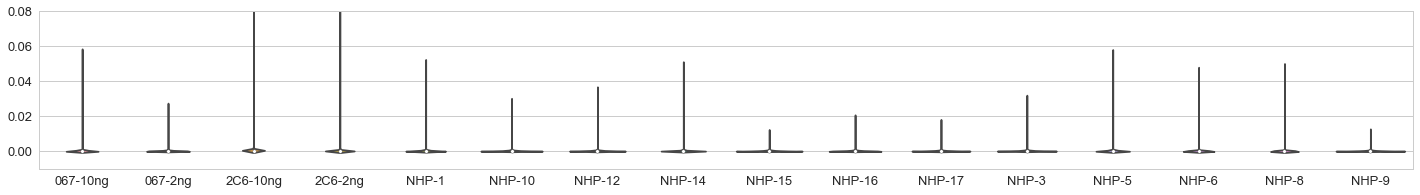

In [43]:
plt.subplots(figsize=(20,3))
sns.violinplot(data=aggregated_output, order=sorted(aggregated_output.columns.values))
plt.ylim(-.01, 0.08)
plt.tight_layout()

In [31]:
# def standardize(df):
#     ''' Standardize each column of the data frame such that mean = 0 and stddev = 1 '''
#     df = df.sub(df.mean(0), axis='columns').div(df.std(0), axis='columns')
#     return df

# def normalize(df):
#     ''' Normalize each column of the data frame so it ranges from 0 to 1'''
#     xmin = df.min(0)
#     xmax=df.max(0)
#     xmax_minus_xmin = xmax - xmin
#     df = df.sub(xmin, axis='columns').div(xmax_minus_xmin, axis='columns').multiply(100.)
#     return df

# def calc_enrichment(column, input_vals = input_counts['average'], background_vals = background_counts['average']):
#     ''' Naive first pass: output/input - background/input '''
#     background_enrichment = background_vals.div(input_vals)
#     column_enrichment = column.div(input_vals)
#     enrichment = column_enrichment.sub(background_enrichment)
#     enrichment[enrichment<0] = 0. # Take min(score, 0)
#     return enrichment

# enrichment = output_counts.apply(calc_enrichment, axis=0)

# ### This has some issues, mainly that the background is only normalized to itself, so it's highly overrepresented. TODO

In [17]:
#### Subtract out the background after correcting for read depth between background and exp. 
#### But, these seem to be fairly close to each other, making this not super useful.

# # #### Find the total number of reads in each control sample.
# total_bkgd_depth = counts[[c for c in counts.columns.values 
#                            if 'bead' in c.lower() and c not in funky_background_replicates]
#                          ].sum()
# # #### Find the average total number of reads in control samples
# avg_bkgd_depth = total_bkgd_depth.mean()

# total_output_counts = output_counts.sum()
# depth_above_bkgd = total_output_counts.divide(avg_bkgd_depth)

# depth_adjusted_output = output_proportions.multiply(depth_above_bkgd)

# output_minus_bkgd = depth_adjusted_output.subtract(bkgd_ctrl['average'], axis='rows')